# Stage 2: Latent time predicted by scLTNN (Panceras)

Here, you will be briefly guided through the basics of how to use scLTNN. Once you are set, the following tutorials go straight into analysis of latent time by raw count of scRNA-seq.

In this tutorial, this started out as a demonstration that scLTNN would allow to reproduce most of latent time of scVelo. Compare with scVelo, it is applied to endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells. See here for more details. It can be applied to your own data along the same lines.

In [ ]:
# update to the latest version, if not done yet.
!pip install scltnn --upgrade --quiet

In [1]:
import scltnn
import scanpy as sc
import scvelo as scv
import anndata

In [2]:
import omicverse as ov
ov.utils.ov_plot_set()

## Load the data
The analysis is based on the in-built pancreas data.

In [3]:
#adata=sc.read_h5ad('../../data/Pancreas-velocyto.h5ad')
adata=scltnn.datasets.Pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Preprocess the Data
Preprocessing requisites consist of gene selection by detection (with a minimum number of counts) and high variability (top 10,000 genes), normalizing every cell by its total size and logarithmizing X.

In [4]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata=adata[:,adata.var['highly_variable_features']==True]
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 3696
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 12261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 56.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
    Scrublet finished (0:00:02)
Cells retained after scrublet: 3688, 8 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresho

View of AnnData object with n_obs × n_vars = 3688 × 3000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'highly_variable_genes', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'scrublet', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

## Calculate the latent semantic index (lsi)
We need to calculate the lsi of scRNA-seq and thus obtain the potential timing topics for each cell

In [5]:
scltnn.lsi(adata, n_components=20, n_iter=15)

## Visualize the celltype

In [6]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [7]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

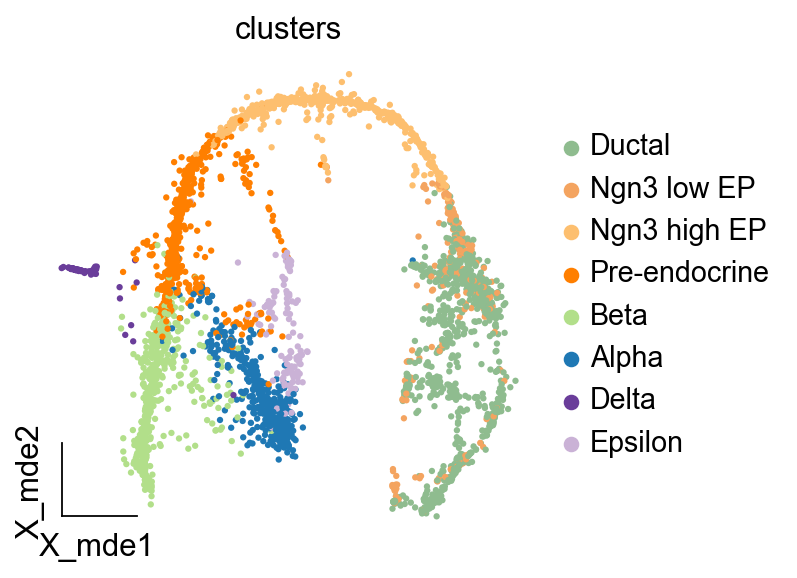

In [8]:
ov.utils.embedding(adata,basis='X_mde', color=['clusters'], 
               cmap='PuRd',legend_loc='right margin',frameon='small')

## Init the scLTNN model

The model can be downloaded from [figshare](https://figshare.com/articles/dataset/scltnn_data/20383416)

In [9]:
scpancera=scltnn.scLTNN(adata,basis='X_lsi',input_dim=20,cpu='cpu')
scpancera.ANNmodel_load('../../model/model_mouse.h5')

## Calculate the PAGA 
For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away. But in scLTNN, you only need to use `scLTNN.cal_page` to complete this calculation.

In [10]:
scpancera.cal_paga(use_rep='scaled|original|X_pca',resolution=2)

......calculate paga
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


## Calculate the pre-model time
We have computed some single-cell latent times in advance by scVelo and trained an artificial neural network (ANN) model with these latent times. We can use these known models to initially determine the starting and ending points of the evolution of our single-cell atlas.

In [11]:
scpancera.cal_model_time()

......predict model_time


## Calculate the expression-related gene value

Sometimes, the starting point and the end point determined by our model are just opposite, in order to avoid this situation, we calculate the mean value of expression-related gene for quantitative analysis. As stem cells become more differentiated and more like adult cells, they express fewer and fewer genes. Here, we determine the node with high expression-related gene as the starting node and the node with low expression-related gene as the end node.


In [12]:
scpancera.cal_exp_gene_value()
scpancera.cal_dpt_pseudotime(leiden_range_start=0.1,
                             leiden_range_mid=0.2,
                             leiden_range_end=0.05)

......calculate dpt_pseudotime
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9988067  0.99221116 0.9867448  0.9785721  0.9732365
     0.9682831  0.961349   0.95731074 0.95364136 0.9505648  0.947223
     0.9386252  0.9373304  0.9231994 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
......leiden_start: ['12', '11', '15']
......leiden_middle ['7', '4', '10', '6', '18']
......leiden_end ['1', '5', '3', '9']


## Trainning the ANN model
We select the newly determined starting point and the end point, construct a normal distribution with mean 0.03 and 0.97 for the starting point and end point respectively, and then use the starting point and end point regression ANN model to predict the time series data of all cells

In [13]:
scpancera.ANN(batch_size=30,n_epochs=200,verbose=0)

......ANN


ANN model: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.20it/s, val loss, val mae=0.00175, 0.00175]


## Calculate the distribution of PAGA graph and ANN model
We use 10 common distributions to fit the distribution to the diffusion pseudotime of the PAGA graph and the time of the ANN model regression, respectively. 

**Note** (In general, the distribution obtained from the PAGA graph is dweibull and the distribution obtained from the ANN model is norm)

In [14]:
scpancera.cal_distrubute()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 16.3315] [loc=0.582 scale=0.353]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 16.0563] [loc=0.000 scale=0.582]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 16.0563] [loc=-33554432.000 scale=33554432.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 6.84538] [loc=0.471 scale=0.387]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 16.3313] [loc=0.582 scale=0.353]


......Dweibull analysis


[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 10.4245] [loc=0.565 scale=0.391]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 16.549] [loc=-4.661 scale=0.024]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 16.3909] [loc=-65.545 scale=66.125]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 10.529] [loc=-0.029 scale=1.029]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 12.2444] [loc=0.000 scale=1.000]
[distfit] >INFO> [loggamma  ] [0.00 sec] [RSS: 9.52984] [loc=0.971 scale=0.014]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 14.3198] [loc=0.553 scale=0.344]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 14.365] [loc=-0.016 scale=0.569]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 14.365] [loc=-33554432.016 scale=33554432.000]
[distfit] >INFO> [dweibull  ] [0.01 sec] [RSS: 11.1783] [loc=0.632 scale=0.356]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 14.3195] [loc=0.553 scale=0.3

......Norm analysis


[distfit] >INFO> [genextreme] [0.05 sec] [RSS: 11.7847] [loc=0.525 scale=0.407]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 14.3615] [loc=-5.928 scale=0.018]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 14.3167] [loc=-40.105 scale=40.658]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 9.98784] [loc=-0.016 scale=1.031]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 10.9439] [loc=-0.016 scale=1.030]
[distfit] >INFO> [loggamma  ] [0.01 sec] [RSS: 11.1052] [loc=0.988 scale=0.012]
[distfit] >INFO> Compute confidence intervals [parametric]


## Calculate the LTNN time
In this step, we combine the results of the PAGA graph with the ANN model, reinforcing the intermediate values of the PAGA graph (using the ANN model normal distribution as a parameter) and reinforcing the two end values of the ANN model (using the dweibull distribution of the PAGA grapha as a parameter).

In [15]:
scpancera.cal_scLTNN_time()

......calculate scLTNN time


## Visualization
We can compare the real differentiation stage of zebrafish and the LTNN time, and thus confirm that our predicted latent time is reliable

--> added 'pos', the PAGA positions (adata.uns['paga'])


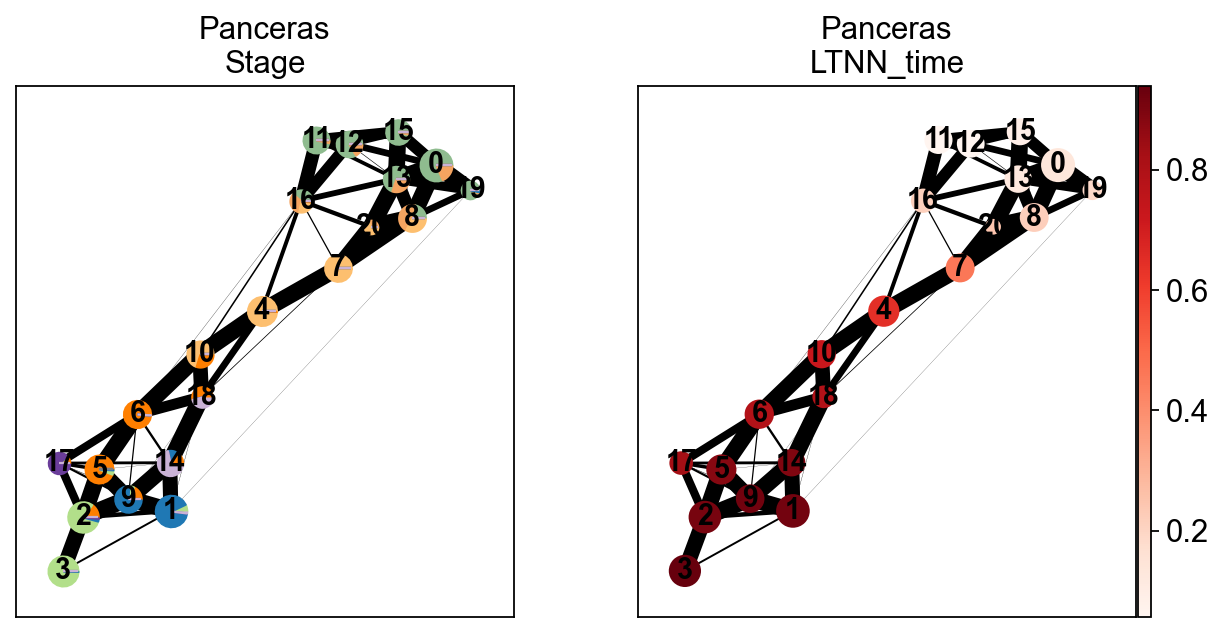

In [16]:
sc.pl.paga(scpancera.adata, color=['clusters','LTNN_time'],cmap='Reds',
          title=['Panceras\nStage','Panceras\nLTNN_time'],)
          #save='_fig3_pancreas.png')

[<AxesSubplot: title={'center': 'clusters'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'LTNN_time'}, xlabel='X_mde1', ylabel='X_mde2'>]

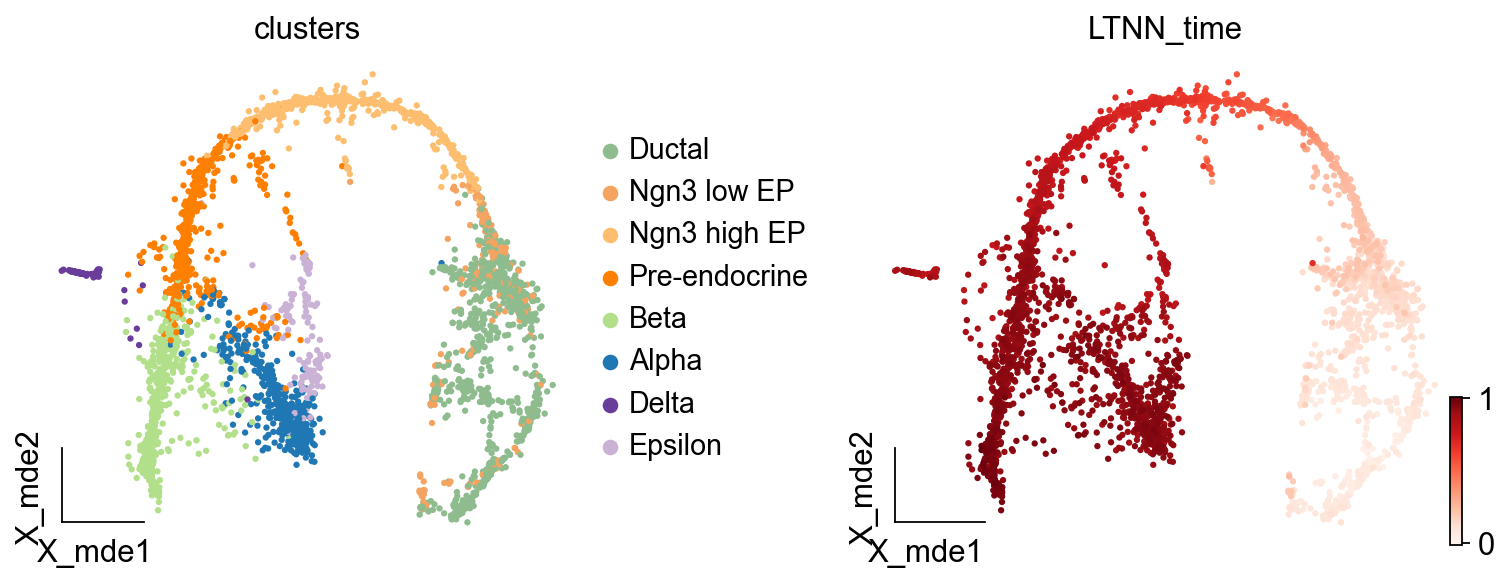

In [17]:
ov.utils.embedding(scpancera.adata,basis='X_mde', color=['clusters','LTNN_time'], 
               cmap='Reds',legend_loc='right margin',frameon='small',
                   ncols=2,wspace=0.4,show=False)

## Find the related-gene of LTNN_time
A easy function `scltnn.utils.find_high_correlation_gene` we provide to find out the LTNN-time related genes

Besides,we also provide another easy function `scltnn.plot.plot_high_correlation_heatmap` to visualize the gene and time

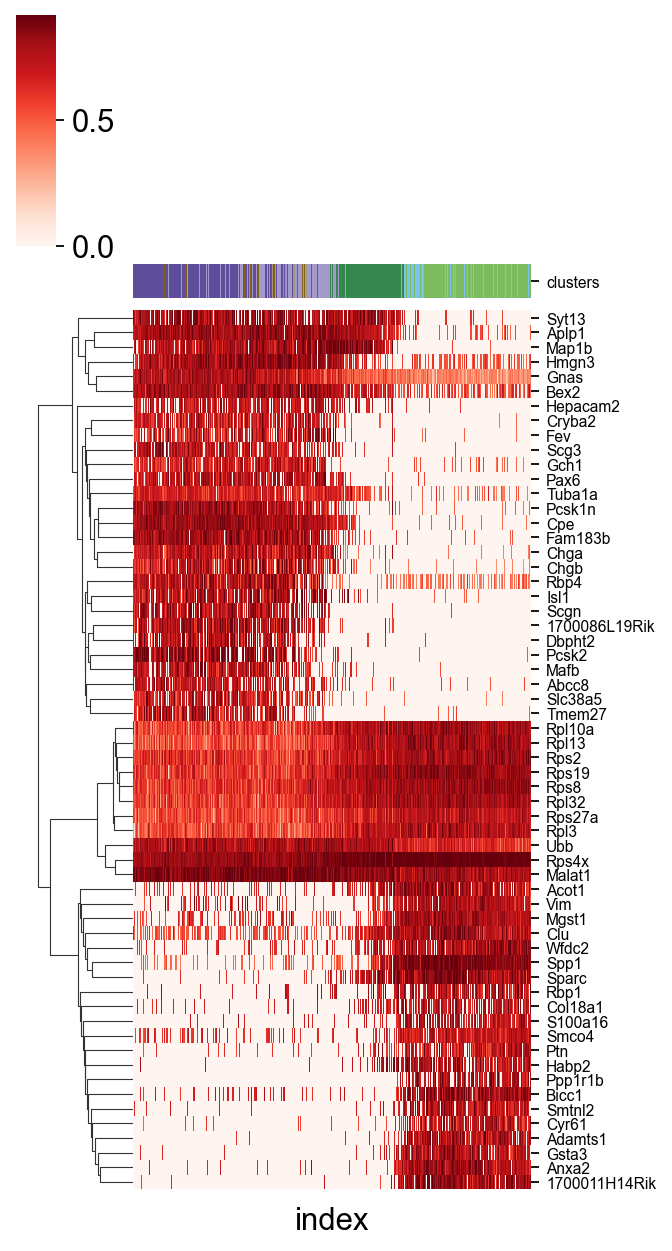

In [20]:
import seaborn as sns
LTNN_time_Pearson,adata_1=scltnn.models.find_high_correlation_gene(scpancera.adata,rev=False)
scltnn.plot.plot_high_correlation_heatmap(adata_1,LTNN_time_Pearson,fontsize=7,standard_scale=0,
                              meta=['clusters'],figsize=(5,8),number=30,cmap='Reds',
                             meta_legend=True,meta_legend_kws={'ncol':2,'distance':20,'interval':3})
#plt.savefig('heatmap_mouse.png',dpi=300,bbox_inches = 'tight')

## Visualize the origin and Tesmination cell 
A easy function `scltnn.plot.plot_origin_tesmination` we provide to visualize the origin and tesmination cell clusters


(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'Mouse\nOrigin and Tesmination'}, xlabel='X_mde1', ylabel='X_mde2'>)

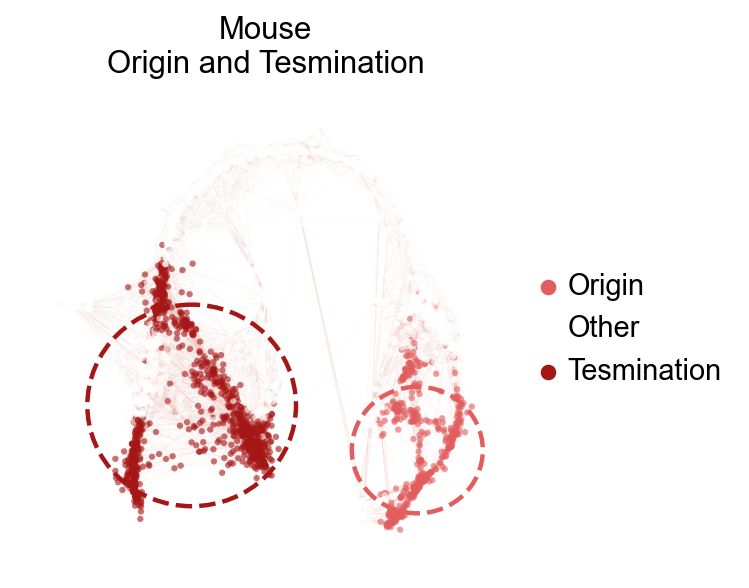

In [21]:
#sc.tl.umap(scpancera.adata_test)
scltnn.models.plot_origin_tesmination(scpancera.adata,basis='X_mde',origin=['11', '12', '15'],
                                     tesmination=['3', '1', '9', '5'],
                                      edges=True,edges_color='#f4897b',edges_width=0.01,
                                   title='Mouse\nOrigin and Tesmination',alpha=0.6,
                                   frameon=False,legend_fontsize=13,figsize=(4,4))

## Visualize the trajectory by LTNN time

To get some intuition for this transition matrix, we can project it into an embedding and draw the same sort of arrows that we all got used to from RNA velocity - the following plot will look exactly like the plots you’re used to from scVelo for visualizing RNA velocity, however, there’s no RNA velocity here (feel free to inspect the AnnData object closely), we’re visualizing the directed transition matrix we computed using the KNN graph as well as the LTNN pseudotime.

In [22]:
ptk = scltnn.PseudotimeKernel(scpancera.adata,time_key='LTNN_time')
ptk

PseudotimeKernel[n=3688]

In [23]:
ptk.compute_transition_matrix()
ptk.compute_projection(basis='mde')

  0%|          | 0/3688 [00:00<?, ?cell/s]

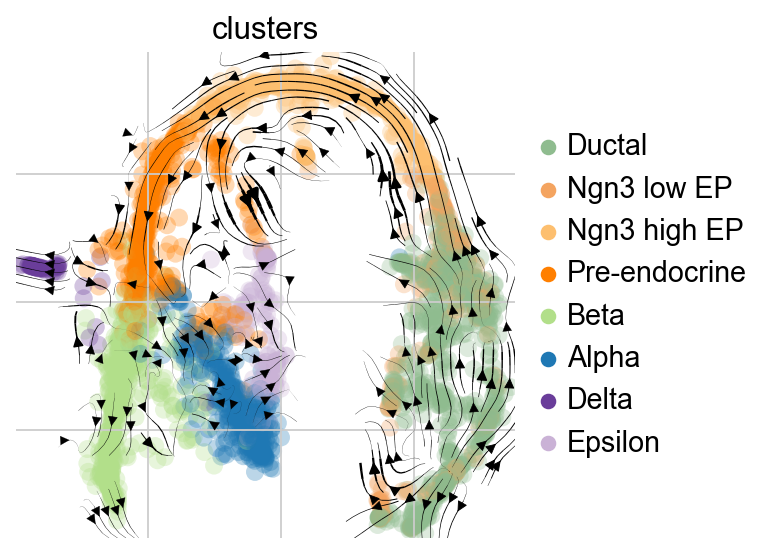

In [24]:
scv.pl.velocity_embedding_stream(scpancera.adata,vkey='T_fwd', basis='mde',
                                smooth=1,min_mass=2,
                                color='clusters',legend_loc='right margin')

<Axes: ylabel='dpt_pseudotime'>

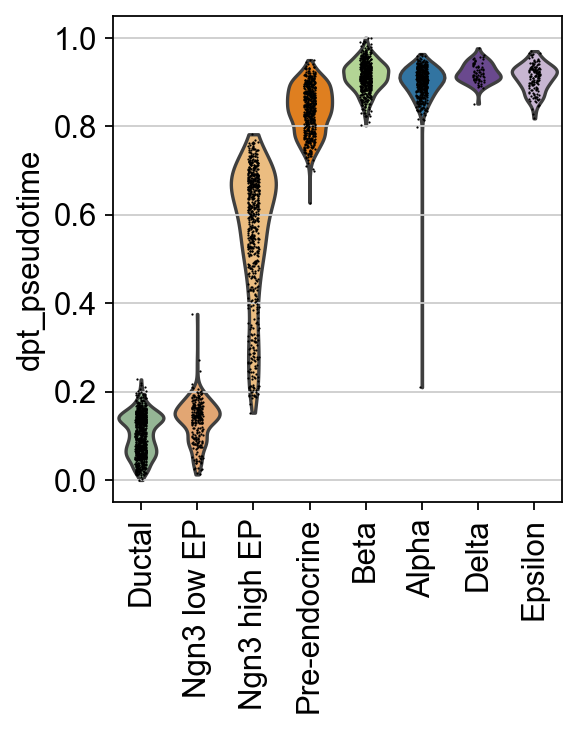

In [26]:
sc.pl.violin(scpancera.adata, keys=["dpt_pseudotime"],
             groupby="clusters", rotation=90,show=False)


In [27]:
scpancera.adata.uns['paga_graph']=scpancera.adata.obsp['connectivities']
scv.tl.paga(scpancera.adata, groups='clusters',vkey='paga',use_time_prior='LTNN_time')

running PAGA using priors: ['LTNN_time']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

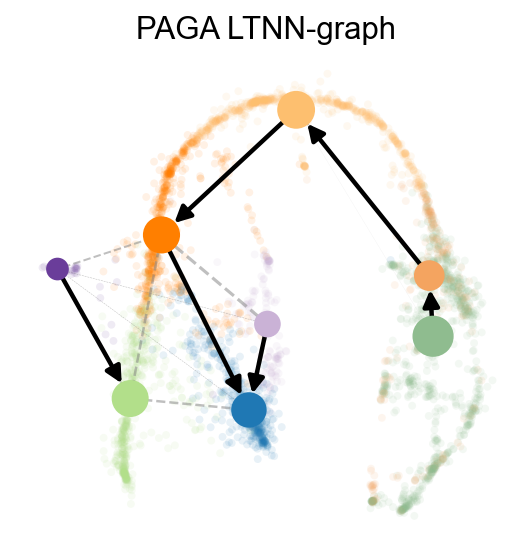

In [28]:
scv.pl.paga(scpancera.adata, basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)